# Proyecto Cancer Bucal

## Librerias

In [1]:
##Librerias
import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Contar Imagenes Procesadas

In [2]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
       #Conteo de numero de imagenes dentro de las Carpetas
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

path = r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Preprocesadas';
DatasetSize = GetDatasetSize(path);
print(DatasetSize);

{'cancer': 500, 'non-cancer': 450}


## División de Datos 

70% Datos Entrenamiento
15% Datos Validación
15% Datos Testeo

In [3]:

def TrainValTestSplit(root_dir, classes_dir, val_ratio=0.15, test_ratio=0.15):
    for cls in classes_dir:
        train_path = os.path.join(r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Entrenamiento', cls)
        val_path = os.path.join(r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Validacion', cls)
        test_path = os.path.join(r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Testeo', cls)

        os.makedirs(train_path, exist_ok=True)
        os.makedirs(val_path, exist_ok=True)
        os.makedirs(test_path, exist_ok=True)

        src = os.path.join(root_dir, cls)

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames) * (1 - (val_ratio + test_ratio))), int(len(allFileNames) * (1 - test_ratio))])

        train_FileNames = [os.path.join(src, name) for name in train_FileNames.tolist()]
        val_FileNames = [os.path.join(src, name) for name in val_FileNames.tolist()]
        test_FileNames = [os.path.join(src, name) for name in test_FileNames.tolist()]

        print(cls.upper(), ':')
        print('Total Imagenes: ', len(allFileNames))
        print('Entrenamiento: ', len(train_FileNames))
        print('Validación: ', len(val_FileNames))
        print('Testeo: ', len(test_FileNames))

        for name in train_FileNames:
            shutil.copy(name, train_path)

        for name in val_FileNames:
            shutil.copy(name, val_path)

        for name in test_FileNames:
            shutil.copy(name, test_path)
        print()

root_dir = r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Procesadas'
classes_dir = ['cancer', 'non-cancer']  # Classes
TrainValTestSplit(root_dir, classes_dir)


CANCER :
Total Imagenes:  464
Entrenamiento:  324
Validación:  70
Testeo:  70

NON-CANCER :
Total Imagenes:  435
Entrenamiento:  304
Validación:  65
Testeo:  66



# Construcción Modelos

## DenseNet - 121

In [4]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
import numpy as np

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives + false_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_negatives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_positives / (true_positives + false_negatives + K.epsilon())

modelo_DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in modelo_DenseNet121.layers:
    layer.trainable = False

def crea_modelo_DenseNet121(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  
    predictions = Dense(1, activation='sigmoid')(x)

    modelo_combinado_DenseNet121 = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.0001)  # Ajusta la tasa de aprendizaje
    modelo_combinado_DenseNet121.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', specificity, sensitivity])

    return modelo_combinado_DenseNet121

densenet_121 = crea_modelo_DenseNet121(modelo_DenseNet121)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Entrenamiento', target_size=(256,256), batch_size=32, class_mode='binary')
val_data = val_datagen.flow_from_directory(directory=r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Validacion', target_size=(256,256), batch_size=32, class_mode='binary')

checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


densenet121 = densenet_121.fit(
    train_data,
    steps_per_epoch=2,
    epochs=200,
    validation_data=val_data,
    validation_steps=1,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Agrega los callbacks aquí
)


y_true = val_data.labels
y_pred = densenet_121.predict(val_data)
val_loss, val_accuracy, val_specificity, val_sensitivity = densenet_121.evaluate(val_data)
print(f"Loss: {val_loss}, Accuracy: {val_accuracy}, Specificity: {val_specificity}, Sensitivity: {val_sensitivity}")


Found 899 images belonging to 2 classes.
Found 893 images belonging to 2 classes.
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4844 - loss: 0.8036 - sensitivity: 0.5234 - specificity: 0.5391  
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to pt_control_modelo.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 19s/step - accuracy: 0.4792 - loss: 0.8148 - sensitivity: 0.5104 - specificity: 0.5312 - val_accuracy: 0.5000 - val_loss: 0.7250 - val_sensitivity: 0.4375 - val_specificity: 0.1875
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5234 - loss: 0.7517 - sensitivity: 0.3281 - specificity: 0.3828
Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.5208 - loss: 0.7628 - sensitivity: 0.3333 - specificity: 0.3958 - val_accuracy: 0.4062 - val_loss: 0.7852 - val_sensitivity: 0.5938 - val_specificity: 0.7500
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5938 - loss: 0.7597 - sensitivity: 0.476

In [5]:
print(f"Accuracy DenseNet121 = {val_accuracy * 100} %")
print(f"Perdida DenseNet121 = {val_loss * 100} %")
print(f"Especificidad DenseNet121 = {val_specificity * 100} %")
print(f"Sensibilidad DenseNet121 = {val_sensitivity * 100} %")

Accuracy DenseNet121 = 88.24188113212585 %
Perdida DenseNet121 = 31.59824311733246 %
Especificidad DenseNet121 = 55.45335412025452 %
Sensibilidad DenseNet121 = 48.264315724372864 %


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf

# Fijar semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Funciones adicionales para métricas
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives + false_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    return true_positives / (true_positives + false_negatives + K.epsilon())

# Crear el modelo base DenseNet121
modelo_DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in modelo_DenseNet121.layers:
    layer.trainable = False

def crea_modelo_DenseNet121(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    modelo_combinado_DenseNet121 = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.0001)
    modelo_combinado_DenseNet121.compile(optimizer=optimizer, loss='binary_crossentropy', 
                                         metrics=['accuracy', specificity, sensitivity])
    return modelo_combinado_DenseNet121

densenet_121 = crea_modelo_DenseNet121(modelo_DenseNet121)

# Data Augmentation y Generadores de Datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    directory=r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Entrenamiento',
    target_size=(256, 256), batch_size=32, class_mode='binary', seed=SEED)

val_data = val_datagen.flow_from_directory(
    directory=r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Validacion',
    target_size=(256, 256), batch_size=32, class_mode='binary', seed=SEED)

# Extraer datos del generador para usar en validación cruzada
X_train_full = []
y_train_full = []
for i in range(len(train_data)):
    X_train_full.append(train_data[i][0])
    y_train_full.append(train_data[i][1])
X_train_full = np.vstack(X_train_full)
y_train_full = np.hstack(y_train_full)

# Callbacks
checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Validación Cruzada K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
kfold_results = []

for train_index, val_index in kf.split(X_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    model = crea_modelo_DenseNet121(modelo_DenseNet121)

    history_kfold = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping_callback]
    )

    scores = model.evaluate(X_val, y_val)
    kfold_results.append(scores)



# Entrenamiento inicial completo
history = densenet_121.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=50,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler]
)

# Descongelar capas superiores del modelo base
for layer in modelo_DenseNet121.layers[-50:]:
    layer.trainable = True

densenet_121.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', 
                     metrics=['accuracy', specificity, sensitivity])

# Entrenamiento con capas descongeladas
history_fine_tune = densenet_121.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=50,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler]
)

# Evaluar y calcular métricas adicionales
y_true = val_data.labels
y_pred = densenet_121.predict(val_data)
y_pred_binary = (y_pred > 0.5).astype(int)

val_loss, val_accuracy, val_specificity, val_sensitivity = densenet_121.evaluate(val_data)
auc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred_binary)







Found 899 images belonging to 2 classes.
Found 893 images belonging to 2 classes.
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.6220 - loss: 0.6753 - sensitivity: 0.3878 - specificity: 0.5909 - val_accuracy: 0.8389 - val_loss: 0.4071 - val_sensitivity: 0.3332 - val_specificity: 0.6312
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8337 - loss: 0.4248 - sensitivity: 0.4241 - specificity: 0.5607 - val_accuracy: 0.8722 - val_loss: 0.3235 - val_sensitivity: 0.4005 - val_specificity: 0.5583
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8351 - loss: 0.3874 - sensitivity: 0.4189 - specificity: 0.5643 - val_accuracy: 0.9000 - val_loss: 0.2901 - val_sensitivity: 0.4249 - val_specificity: 0.5323
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8355 - loss: 0.3376 - sensitivity: 0.4465 - specificity: 0.5379 - val_accuracy: 0.9000 - val_loss: 0.2713 - val_sensitivity: 0.4249 - val_specificity: 0.5323
Epoch 5/10
23/23 ━━━━━━━━━━━━━

In [ ]:
print(f"Loss: {val_loss}, Accuracy: {val_accuracy}, Specificity: {val_specificity}, Sensitivity: {val_sensitivity}, AUC: {auc}, F1-Score: {f1}")


In [ ]:
print("Resultados de la validación cruzada K-Fold:")
print(kfold_results)

# Graficos DenseNet 121

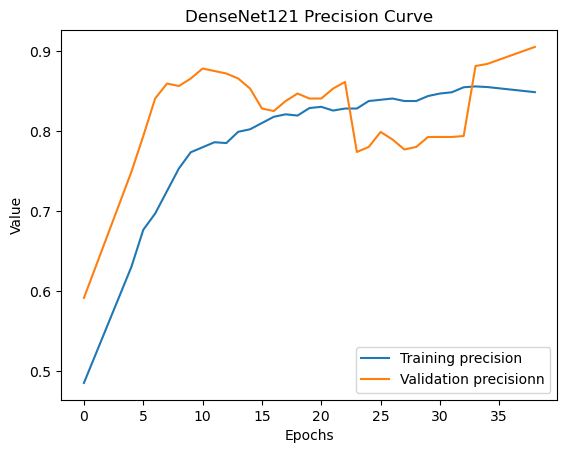

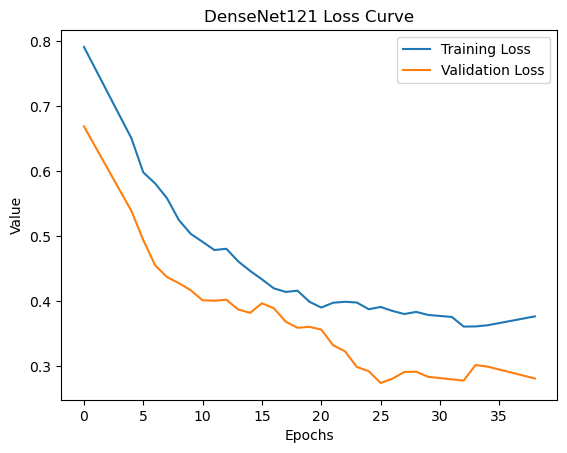

In [7]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

training_accuracy_densenet121 = densenet121.history['accuracy']
training_loss_densenet121 = densenet121.history['loss']
validation_accuracy_densenet121 = densenet121.history['val_accuracy']
validation_loss_densenet121 = densenet121.history['val_loss']

smoothed_training_accuracy121 = savgol_filter(training_accuracy_densenet121, window_length=10, polyorder=1)
smoothed_training_loss121 = savgol_filter(training_loss_densenet121, window_length=10, polyorder=1)
smoothed_validation_accuracy121 = savgol_filter(validation_accuracy_densenet121, window_length=10, polyorder=1)
smoothed_validation_loss121 = savgol_filter(validation_loss_densenet121, window_length=10, polyorder=1)

plt.plot(smoothed_training_accuracy121, label='Training precision')
plt.plot(smoothed_validation_accuracy121, label='Validation precisionn')
plt.title('DenseNet121 Precision Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(smoothed_training_loss121, label='Training Loss')
plt.plot(smoothed_validation_loss121, label='Validation Loss')
plt.title('DenseNet121 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


In [15]:
# Guardar Modelo Entrenado con mejor desempeño
densenet_121.save("Modelo_densenet121.hdf5")